# Neural network from scratch.

Based on YSDA Deep Learning course materials.

https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework01/homework_modules.ipynb

We will implement most common layers using `numpy` for matrix operations. 

The file `modules.py` contains the abstract classes for **module**, **criterion** and **sequential** model class.

**Module** is an abstract class which defines the fundamental methods required for training a neural network.

**Criterion** class implements a container which can be used to score the models answers. 

**Sequential** class implements a container which processes `input` data sequentially. 


#### Tips and tricks
Original `numpy` operation are preferable to the overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They are less prone to excess memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

But I won't follow that advice ;)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


In [9]:
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/week0_08_intro_to_DL/modules.py


class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:
        output = module.forward(input)
    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.
        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self, input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        The shape of `gradInput` is always the same as the shape of `input`.
        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"


class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})
        Just write a little loop.
        """

        # Your code goes here. ################################################
        self.output = input

        for module in self.modules:
            self.output = module.forward(self.output)

        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)
        !!!
        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.
        !!!
        """
        # Your code goes here. ################################################

        for i in range(len(self.modules)-1, 0, -1):
            gradOutput = self.modules[i].backward(self.modules[i-1].output, gradOutput)

        self.gradInput = self.modules[0].backward(input, gradOutput)

        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()


class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.
            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

## Impelementing main layers


Let's try to implement some layers in numpy. 
Today we are going to discuss only the most common ones.

https://en.wikipedia.org/wiki/Matrix_calculus



[Post about einsum](https://habr.com/ru/post/544498/)

### 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_in`**
- output  **`batch_size x n_out`**

[Backpropagation for a Linear Layer handout](http://cs231n.stanford.edu/handouts/linear-backprop.pdf)

In [10]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        ################################################
        # your code here 
        self.output = np.matmul(input, self.W) + self.b
        ################################################
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        ################################################
        # your code here 
        self.gradInput = np.matmul(gradOutput, self.W.T)
        ################################################
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        ################################################
        # your code here
        self.gradW += np.matmul(input.T, gradOutput)
        self.gradb += np.sum(gradOutput, axis=0)
        ################################################
        pass
            
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

### 2. SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

[Notes on softmax](https://deepnotes.io/softmax-crossentropy)

In [11]:
# simple einsum example 
p = np.arange(6).reshape((2, 3))
np.einsum('bi,bj->bij', p, p)

array([[[ 0,  0,  0],
        [ 0,  1,  2],
        [ 0,  2,  4]],

       [[ 9, 12, 15],
        [12, 16, 20],
        [15, 20, 25]]])

In [12]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        ################################################
        # start with normalization for numerical stability
        # your code here 
        shifted_input = input - np.max(input, axis=1, keepdims=True)
        self.output = np.exp(shifted_input)
        self.output /= np.sum(self.output, axis=1, keepdims=True)
        ################################################
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        ################################################
        # First we create for each example feature vector, it's outer product with itself
        # ( p1^2  p1*p2  p1*p3 .... )
        # ( p2*p1 p2^2   p2*p3 .... )
        # ( ...                     )
        # your code here 
        local_repr_1 = np.einsum('bi,bj->bij', self.output, self.output)
        # Second we need to create an (n_feats, n_feats) identity of the feature vector
        # ( p1  0  0  ...  )
        # ( 0   p2 0  ...  )
        # ( ...            )
        # your code here 
        local_repr_2 = np.einsum('bi,ij->bij', self.output, np.eye(input.shape[1], input.shape[1]))
        # Then we need to subtract the first tensor from the second
        # ( p1 - p1^2   -p1*p2   -p1*p3  ... )
        # ( -p1*p2     p2 - p2^2   -p2*p3 ...)
        # ( ...                              )
        # your code here 
        ################################################
        local_repr = local_repr_2 - local_repr_1
        self.gradInput = np.einsum('bij,bj->bi', local_repr, gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

### 3. Negative LogLikelihood criterion (numerically unstable)
[multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Remember that targets are one-hot encoded. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**## 



In [13]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target):   
        ################################################
        # Use clipping trick to avoid numerical errors
        # your code here 
        clipped_input = np.clip(input, self.EPS, 1 - self.EPS)
        self.output = -np.sum(target * np.log(clipped_input)) / input.shape[0]
        ################################################
        return self.output

    def updateGradInput(self, input, target):
        ################################################
        # Use clipping trick to avoid numerical errors
        # your code here 
        clipped_input = np.clip(input, self.EPS, 1 - self.EPS)
        self.gradInput = - target / clipped_input / input.shape[0]
        ################################################
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"


In [14]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1     

## Toy training example

Use this example to debug your code, just logistic regression. You do not need to change anything here. This code is provided for you to test the layers. 

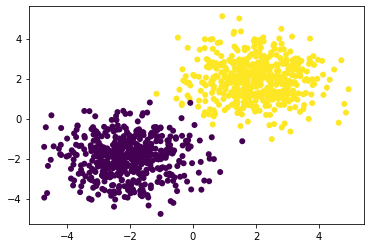

In [15]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [16]:
net = Sequential()
net.add(Linear(2, 2))

net.add(SoftMax())
criterion = ClassNLLCriterionUnstable()

print(net)

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [17]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [18]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

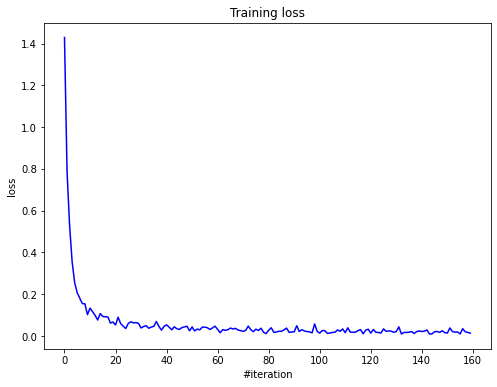

Current loss: 0.013510


In [19]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    